In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import ee
import geemap
from PIL import Image

from os import listdir
from os.path import join
import os
import datetime
import random
from dateutil.relativedelta import relativedelta

import warnings

warnings.filterwarnings('ignore')

ee.Authenticate()
ee.Initialize(project='deepcarbon')

In [ ]:
df = pd.read_csv('fires_uk.csv')
df

latitude  longitude    acq_date
0     55.44560   -2.08140  2017-04-04
1     55.44360   -2.10100  2017-04-04
2     56.74640   -3.14430  2017-04-06
3     51.83090   -3.41170  2017-04-07
4     54.76060   -1.92250  2017-04-08
...        ...        ...         ...
1082  56.91247   -2.80033  2023-10-03
1083  52.95260   -0.11241  2023-10-29
1084  52.94933   -0.09505  2023-10-29
1085  52.95766   -0.10552  2023-10-29
1086  52.95690   -0.09831  2023-10-29

[1087 rows x 3 columns]

In [ ]:
uk = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM0_NAME', 'U.K. of Great Britain and Northern Ireland'))
SBands = ['B2', 'B3','B4', 'B11','B12', 'SCL', 'QA60']

In [ ]:
points = []
for i in range(len(df)):
    points.append(ee.Geometry.Point([df.longitude.values[i], df.latitude.values[i]]))

In [ ]:
bands = ['B2', 'B3','B4', 'B8', 'B11','B12']

# EDA

In [ ]:
def to_array(data_list, point):
    img = ee.Image(data_list).select(bands)
    img = img.addBands(img.pixelLonLat()).reproject('EPSG:4326', scale=10, crsTransform=None)
    roi = point.buffer(2500).bounds()
    array = ee.data.computePixels({
      'expression': img.clip(roi),
      'fileFormat': 'NUMPY_NDARRAY'
    })
    return array

def img_vis(array, kind='RGB', gamma=1.0):
    if kind=='RGB':
        image = np.array([array[bands[2]][:, 192:694],array[bands[1]][:, 192:694],array[bands[0]][:, 192:694]])
        normalized_image = np.transpose((image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image)), (1,2,0))
    else:
        image = array[bands[-1]][:, 192:694]
        normalized_image = (image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image))

    corrected_image = np.power(normalized_image, gamma)
    corrected_image = (corrected_image * 255).astype(np.uint8)

    return corrected_image

def img(i,j, array):
    plt.imshow(img_vis(array, 'RGB'))
    plt.axis('off')
    plt.title('RGB')
    plt.savefig(f'./EDA/RS/{i}_{j}_RGB.jpg')
    #plt.show()

    plt.imshow(img_vis(array, 'SWIR2'))
    plt.axis('off')
    plt.title('SWIR2')
    plt.savefig(f'./EDA/RS/{i}_{j}_SWIR.jpg')

Index: 13/1086	Date: 2017-04-08 00:00:00
Index: 14/1086	Date: 2017-04-08 00:00:00
Index: 15/1086	Date: 2017-04-08 00:00:00
Index: 16/1086	Date: 2017-04-08 00:00:00
Index: 17/1086	Date: 2017-04-08 00:00:00
Index: 25/1086	Date: 2017-05-01 00:00:00
Index: 26/1086	Date: 2017-05-04 00:00:00
Index: 27/1086	Date: 2017-05-04 00:00:00
Index: 28/1086	Date: 2017-05-04 00:00:00
Index: 50/1086	Date: 2017-05-08 00:00:00
Index: 90/1086	Date: 2018-03-24 00:00:00
Index: 91/1086	Date: 2018-03-24 00:00:00
Index: 92/1086	Date: 2018-03-24 00:00:00
Index: 93/1086	Date: 2018-03-24 00:00:00
Index: 135/1086	Date: 2018-06-26 00:00:00
Index: 136/1086	Date: 2018-06-26 00:00:00
Index: 137/1086	Date: 2018-06-26 00:00:00
Index: 138/1086	Date: 2018-06-26 00:00:00
Index: 139/1086	Date: 2018-06-26 00:00:00
Index: 140/1086	Date: 2018-06-26 00:00:00
Index: 141/1086	Date: 2018-06-26 00:00:00
Index: 143/1086	Date: 2018-06-26 00:00:00
Index: 144/1086	Date: 2018-06-26 00:00:00
Index: 145/1086	Date: 2018-06-26 00:00:00
Index:

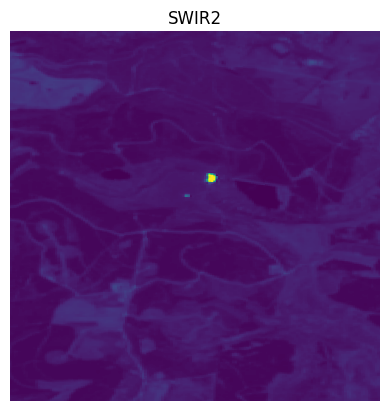

In [ ]:
dates, coords = [], []
idx = set([int(file.split('_')[0]) for file in listdir('./S2_img')])
for i in range(len(df)):
    if i in idx:
        startDate = pd.to_datetime(df.acq_date.values[i])
        endDate = startDate+datetime.timedelta(days=1)

        data = ee.ImageCollection(f"COPERNICUS/S2_SR_HARMONIZED")\
                    .filterDate(startDate.strftime('%Y-%m-%d'), endDate.strftime('%Y-%m-%d'))\
                    .filterBounds(points[i].buffer(2500).bounds())\
                    .select(bands)

        if data.size().getInfo()!=0:
            data_list = data.toList(data.size())
            for j in range(data_list.size().getInfo()):
                if f'{i}_{j}.jpg' in listdir('./S2_img'):
                    array = to_array(data_list.get(j), points[i])

                    dates.append(startDate)
                    coords.append(points[i])

                    np.save(join('./EDA/RS',f'{i}_{j}.npy'), array)
                    img(i,j, array)

            print(f'Index: {i}/{len(df)-1}\tDate: {startDate}')
np.save('coords.npy', coords)
np.save('dates.npy', dates)
print('Done')

# EDA Masking

In [ ]:
def murphy_mask(full_array, B):
    indexes = np.where(((full_array[B[-1]]/full_array[B[3]])>1.4)&\
                       ((full_array[B[-1]]/full_array[B[4]])>1.4)&\
                        ((full_array['B12']*0.0001)>=0.15))
    hotspots = list(zip(indexes[0], indexes[1]))
    return hotspots

499959


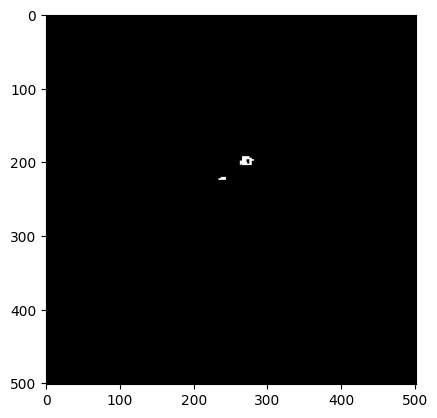

In [ ]:
files = listdir('./EDA/RS')
all_f = 0
for file in files:
    if file.split('.')[-1]=='npy':
        date = int(df.iloc[int(file.split('.')[0].split('_')[0])].acq_date[:4])
        full_array = np.load('./EDA/RS/'+file, allow_pickle=True)[:][:, 192:694]
        fire_pixels = murphy_mask(full_array, bands)

        mask = np.zeros(full_array.shape)
        for coord in fire_pixels:
            mask[coord] = 1
        plt.imshow(mask, cmap='Greys_r')
        image = Image.fromarray(mask.astype(np.uint8)*255)
        image.save(f"./EDA/RS/{file.replace('.npy', '_mask.jpg')}")
        all_f+=len(fire_pixels)
print(all_f)

# EDA Before & After

In [ ]:
def to_array(img, B, point):
    img = ee.Image(img).select(B)
    img = img.addBands(img.pixelLonLat()).reproject('EPSG:4326', scale=10, crsTransform=None)
    roi = point.buffer(2500).bounds()
    array = ee.data.computePixels({
      'expression': img.clip(roi),
      'fileFormat': 'NUMPY_NDARRAY'
    })
    return array

In [ ]:
DF = pd.read_csv('Reflectance.csv', index_col=0)

In [ ]:
files = [x for x in listdir('./EDA/RS') if x.split('.')[-1]=='npy']
dates = np.load('dates.npy', allow_pickle=True)
columns = ['B', 'G', 'R', 'NIR', 'SWIR1', 'SWIR2', 'lon', 'lat']
D = {}
for f, file in enumerate(files):
    if int(file.split('_')[0])!=368 and int(file.split('_')[0])>=832:
        print(file)
        idx = int(file.split('_')[0])
        jdx = int(file.split('_')[1].split('.')[0])
        startDate = pd.to_datetime(df.acq_date.values[idx])+relativedelta(months=-1)
        endDate = pd.to_datetime(df.acq_date.values[idx])+relativedelta(months=+1)

        data = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
                    .filterDate(startDate.strftime('%Y-%m-%d'), endDate.strftime('%Y-%m-%d'))\
                    .filterBounds(points[idx].buffer(2500).bounds())\
                    .select(bands)
        fire_date = dates[f]

        if data.size().getInfo()!=0:
            data_list = data.toList(data.size())

            for j in range(data_list.size().getInfo()):
                time = data_list.get(j).getInfo()['properties']['system:time_start']/1e3
                date = datetime.datetime.utcfromtimestamp(time).replace(hour=0, second=0, minute=0, microsecond=0)

                if pd.to_datetime(date)==fire_date:
                    fire = 1
                elif pd.to_datetime(date)>fire_date:
                    fire = 2
                elif pd.to_datetime(date)<fire_date:
                    fire = 0

                full_array = to_array(data_list.get(j), bands, points[idx])[:][:, 192:694]

                mask = np.array(Image.open(f'./EDA/RS/{idx}_{jdx}_mask.jpg'))
                mask = (mask > 128).astype(np.uint8)
                full_array = full_array[mask.astype(bool)]

                if len(full_array)!=0:
                    full_array.dtype.names = columns
                    if j==0:
                        df_pix = pd.DataFrame(full_array)
                        df_pix.loc[:, 'date'] = date
                        df_pix.loc[:, 'fire'] = fire
                    else:
                        df_temp = pd.DataFrame(full_array)
                        df_temp.loc[:, 'date'] = date
                        df_temp.loc[:, 'fire'] = fire
                        df_pix = pd.concat([df_pix, df_temp]).reset_index(drop=True)
            print(f'Index: {f}/{len(files)}')
            if f==0:
                DF = df_pix.copy()
            else:
                DF = pd.concat([DF, df_pix]).reset_index(drop=True)

            DF.to_csv('Reflectance.csv')
DF = DF[['date', 'lat', 'lon', 'B', 'G', 'R', 'NIR', 'SWIR1', 'SWIR2', 'fire']]
DF.loc[:, 'B':'SWIR2'] = DF.loc[:, 'B':'SWIR2']*0.0001
DF.to_csv('Reflectance.csv', index=False)
print(DF)

832_0.npy
Index: 183/228
833_0.npy
Index: 184/228
834_0.npy
Index: 185/228
838_0.npy
Index: 186/228
872_0.npy
Index: 187/228
872_1.npy
Index: 188/228
873_0.npy
Index: 189/228
874_0.npy
Index: 190/228
888_0.npy
Index: 191/228
888_1.npy
Index: 192/228
897_0.npy
Index: 193/228
898_0.npy
Index: 194/228
898_1.npy
Index: 195/228
937_0.npy
Index: 196/228
937_1.npy
Index: 197/228
974_0.npy
Index: 198/228
977_0.npy
Index: 199/228
978_1.npy
Index: 200/228
988_0.npy
Index: 201/228
989_1.npy
Index: 202/228
989_3.npy
Index: 203/228
990_1.npy
Index: 204/228
990_3.npy
Index: 205/228
991_1.npy
Index: 206/228
991_3.npy
Index: 207/228
992_1.npy
Index: 208/228
992_2.npy
Index: 209/228
992_3.npy
Index: 210/228
995_1.npy
Index: 211/228
996_1.npy
Index: 212/228
996_2.npy
Index: 213/228
996_3.npy
Index: 214/228
997_1.npy
Index: 215/228
997_3.npy
Index: 216/228
999_0.npy
Index: 217/228
1000_0.npy
Index: 218/228
1014_0.npy
Index: 219/228
1015_0.npy
Index: 220/228
1016_0.npy
Index: 221/228
1017_0.npy
Index: 222

In [ ]:
df = pd.read_csv('Reflectance.csv', index_col=0)
df

lat       lon       B       G       R     NIR  \
date                                                                       
2017-04-08           55.457359 -2.081531  0.1704  0.1707  0.1548  0.2306   
2017-04-08           55.457359 -2.081441  0.1704  0.1707  0.1548  0.2306   
2017-04-08           55.457359 -2.081352  0.1346  0.1380  0.1307  0.2220   
2017-04-08           55.457359 -2.081262  0.1346  0.1380  0.1307  0.2220   
2017-04-08           55.457269 -2.081531  0.1789  0.1840  0.1772  0.2476   
...                        ...       ...     ...     ...     ...     ...   
2023-07-11 00:00:00  51.719200 -3.577406  0.8728  0.8304  0.8216  0.8416   
2023-07-11 00:00:00  51.719200 -3.577316  0.8728  0.8304  0.8216  0.8416   
2023-07-11 00:00:00  51.719200 -3.577226  0.8688  0.8280  0.8216  0.8416   
2023-07-11 00:00:00  51.719200 -3.577136  0.8704  0.8320  0.8192  0.8392   
2023-07-11 00:00:00  51.719200 -3.577047  0.8704  0.8320  0.8192  0.8392   

                      SWIR1   SWIR2  fire  
date                                       
2017-04-08           0.2132  0.4116     1  
2017-04-08           0.2132  0.4116     1  
2017-04-08           0.2132  0.4116     1  
2017-04-08           0.2132  0.4116     1  
2017-04-08           0.2132  0.4116     1  
...                     ...     ...   ...  
2023-07-11 00:00:00  0.3186  0.3070     2  
2023-07-11 00:00:00  0.3186  0.3070     2  
2023-07-11 00:00:00  0.3164  0.3042     2  
2023-07-11 00:00:00  0.3164  0.3042     2  
2023-07-11 00:00:00  0.3164  0.3042     2  

[20492283 rows x 9 columns]

In [ ]:
def NDVI(NIR, R):
    #NDVI measures vegetation health and density.
    return (NIR-R)/(NIR+R)
def NBR(NIR, SWIR2):
    #NBR is specifically designed to identify burned areas and assess burn severity.
    return (NIR-SWIR2)/(NIR+SWIR2)
def BI(R, G):
    #The Brightness Index is used to assess soil brightness, which is influenced by factors like soil moisture, presence of salts,
    #and organic matter content
    return (R**2+G**2)**0.5/3
def BI2(R, G, NIR):
    #Purpose: The BI2 (Second Brightness Index) serves a similar purpose to the BI (Brightness Index) — assessing soil brightness.
    #However, it utilizes a slightly different formula that incorporates an additional spectral band.
    #Significance: Studies have shown that both BI and BI2 exhibit strong correlations with Soil Organic Carbon (SOC) content.
    #This highlights their potential for indirectly estimating SOM through remote sensing analysis.
    return (R**2+G**2+NIR**2)**0.5/3
def SAVI(NIR, R, L=0.5):
    #https://www.usgs.gov/landsat-missions/landsat-soil-adjusted-vegetation-index
    return (NIR-R)/(NIR+R+L)*(1+L)
def SATVI(SWIR2, SWIR1, R, L=0.5):
    #Purpose: SATVI aims to reduce the impact of soil brightness on vegetation analysis similar to SAVI and TVI.
    # SAVI is similar to NDVI but includes a soil brightness correction factor (L) to minimize soil background influence.
    #This index is useful in areas with sparse vegetation.
    return (SWIR1-R)/(SWIR1+R+L)*(1+L)-SWIR2/2
def CSI(SWIR1, SWIR2):
    #Char Soil Index is used to detect charred soil and ash residues post-fire, aiding in the assessment of burn severity.
    return (SWIR1-SWIR2)/(SWIR1+SWIR2)

In [ ]:
df['NDVI'] = NDVI(df.NIR, df.R)
df['NBR'] = NBR(df.NIR, df.SWIR2)
df['BI'] = BI(df.R, df.G)
df['BI2'] = BI2(df.R, df.G, df.NIR)
df['SAVI'] = SAVI(df.NIR, df.R)
df['SATVI'] = SATVI(df.SWIR2, df.SWIR1, df.R)
df['CSI'] = CSI(df.SWIR1, df.SWIR2)

In [ ]:
df[['NDVI', 'NBR', 'BI', 'BI2', "SAVI", 'SATVI', 'CSI', 'fire']].reset_index(drop=True).to_csv('Indexes.csv', index=False)

In [ ]:
del df

# ERA5

In [ ]:
bands = ['mean_2m_air_temperature', 'total_precipitation','surface_pressure']

In [ ]:
def get_means(image):
    date = ee.Date(ee.Image(image).get('system:time_start')).format('YYYY-MM-dd')
    means = ee.Image(image).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry= points[idx].buffer(2500).bounds(),
        scale=2500
    )
    return ee.Feature(None, {'date': date, 'means': means})

def stack(L):
    for i in range(len(L)):
        D = L[i]['properties'] | L[i]['properties']['means']
        D.pop('means', None)
        if pd.to_datetime(D['date'])==fire_date:
                fire = 1
        elif pd.to_datetime(D['date'])>fire_date:
            fire = 2
        elif pd.to_datetime(D['date'])<fire_date:
            fire = 0
        D['fire']=fire
        if 'df' not in locals():
            df = pd.DataFrame([D])
        else:
            df = pd.concat([df, pd.DataFrame([D])])
    return df

In [ ]:
files = [x for x in listdir('./EDA/RS') if x.split('.')[-1]=='npy']
dates = np.load('dates.npy', allow_pickle=True)
k = 0
for f, file in enumerate(files):
    if int(file.split('_')[0])!=368:
        idx = int(file.split('_')[0])
        jdx = int(file.split('_')[1].split('.')[0])

        startDate = pd.to_datetime(df.acq_date.values[idx])+relativedelta(months=-1)
        endDate = pd.to_datetime(df.acq_date.values[idx])+relativedelta(months=+1)

        data = ee.ImageCollection('ECMWF/ERA5/DAILY')\
                    .filterDate(startDate.strftime('%Y-%m-%d'), endDate.strftime('%Y-%m-%d'))\
                    .filterBounds(points[idx].buffer(2500).bounds())\
                    .select(bands)
        fire_date = dates[f]

        if data.size().getInfo()!=0:
            data_list = data.toList(data.size())
            means = data_list.map(get_means).getInfo()
            sub_df = stack(means)

        if f==0:
            DF = sub_df.copy()
        else:
            DF = pd.concat([DF, sub_df])
        DF.to_csv('meteo.csv', index=False)
        print(f'Index: {f+1}/{len(files)}')
DF = DF[['date', 'mean_2m_air_temperature', 'total_precipitation','surface_pressure' , 'fire']]
DF.to_csv('meteo.csv', index=False)
print(DF)

Index: 1/228
Index: 2/228
Index: 3/228
Index: 4/228
Index: 5/228
Index: 6/228
Index: 7/228
Index: 8/228
Index: 9/228
Index: 10/228
Index: 11/228
Index: 12/228
Index: 13/228
Index: 14/228
Index: 15/228
Index: 16/228
Index: 17/228
Index: 18/228
Index: 19/228
Index: 20/228
Index: 21/228
Index: 22/228
Index: 23/228
Index: 24/228
Index: 25/228
Index: 26/228
Index: 27/228
Index: 28/228
Index: 29/228
Index: 30/228
Index: 31/228
Index: 32/228
Index: 33/228
Index: 34/228
Index: 35/228
Index: 36/228
Index: 37/228
Index: 38/228
Index: 39/228
Index: 40/228
Index: 41/228
Index: 42/228
Index: 43/228
Index: 44/228
Index: 45/228
Index: 46/228
Index: 47/228
Index: 48/228
Index: 49/228
Index: 50/228
Index: 51/228
Index: 52/228
Index: 53/228
Index: 54/228
Index: 55/228
Index: 56/228
Index: 57/228
Index: 58/228
Index: 59/228
Index: 60/228
Index: 61/228
Index: 62/228
Index: 63/228
Index: 64/228
Index: 65/228
Index: 66/228
Index: 67/228
Index: 68/228
Index: 69/228
Index: 70/228
Index: 71/228
Index: 72/228
I

# Lineplots

In [ ]:
import mplcyberpunk

plt.style.use("cyberpunk")

font = {'size': 16}
plt.rc('font', **font)

In [ ]:
import pandas as pd
import duckdb
import numpy as np
import psutil

In [ ]:
def RAM():
    print(f'RAM: {round(psutil.virtual_memory().percent,1)} %\tCPU: {psutil.cpu_percent()} %')
RAM()

RAM: 37.1 %	CPU: 8.6 %


In [ ]:
%load_ext magic_duckdb
con = %dql --getcon

The magic_duckdb extension is already loaded. To reload it, use:
  %reload_ext magic_duckdb


In [ ]:
con = duckdb.connect()

In [ ]:
%%dql
SELECT * FROM 'Indexes.csv';

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

NDVI       NBR        BI       BI2      SAVI     SATVI  \
0         0.196679 -0.281844  0.076813  0.108668  0.128417 -0.104878   
1         0.196679 -0.281844  0.076813  0.108668  0.128417 -0.104878   
2         0.258860 -0.299242  0.063357  0.097417  0.160607 -0.059159   
3         0.258860 -0.299242  0.063357  0.097417  0.160607 -0.059159   
4         0.165725 -0.248786  0.085151  0.118585  0.114187 -0.145153   
...            ...       ...       ...       ...       ...       ...   
20492278  0.012025  0.465436  0.389386  0.479917  0.013868 -0.613505   
20492279  0.012025  0.465436  0.389386  0.479917  0.013868 -0.613505   
20492280  0.012025  0.469017  0.388817  0.479456  0.013868 -0.614737   
20492281  0.012060  0.467903  0.389203  0.479301  0.013899 -0.613215   
20492282  0.012060  0.467903  0.389203  0.479301  0.013899 -0.613215   

               CSI  fire  
0        -0.317542     1  
1        -0.317542     1  
2        -0.317542     1  
3        -0.317542     1  
4        -0.317542     1  
...            ...   ...  
20492278  0.018542     2  
20492279  0.018542     2  
20492280  0.019658     2  
20492281  0.019658     2  
20492282  0.019658     2  

[20492283 rows x 8 columns]

In [ ]:
%%dql
SELECT
    fire,
    AVG(NDVI) AS ndvi_mean,
    AVG(NBR) AS nbr_mean,
    AVG(BI) AS bi_mean,
    AVG(BI2) AS bi2_mean,
    AVG(SAVI) AS savi_mean,
    AVG(SATVI) AS satvi_mean,
    AVG(CSI) AS csi_mean
FROM
    'Indexes.csv'
GROUP BY
    fire;

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

fire  ndvi_mean  nbr_mean   bi_mean  bi2_mean  savi_mean  satvi_mean  \
0     2   0.093354  0.208509  0.202351  0.254518   0.044941   -0.211518   
1     0   0.190180  0.289851  0.161733  0.214608   0.100785   -0.141595   
2     1   0.204813 -0.563686  0.054160  0.078708   0.092477   -0.083109   

   csi_mean  
0  0.079847  
1  0.129612  
2 -0.361576

In [ ]:
query = """
DROP TABLE IF EXISTS Indexes;
CREATE TABLE Indexes AS
SELECT
    fire,
    AVG(NDVI) AS ndvi_mean,
    AVG(NBR) AS nbr_mean,
    AVG(BI) AS bi_mean,
    AVG(BI2) AS bi2_mean,
    AVG(SAVI) AS savi_mean,
    AVG(SATVI) AS satvi_mean,
    AVG(CSI) AS csi_mean
FROM
    'Indexes.csv'
GROUP BY
    fire;"""

con.execute(query)
df = con.execute("SELECT * FROM Indexes;").df()
df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

fire  ndvi_mean  nbr_mean   bi_mean  bi2_mean  savi_mean  satvi_mean  \
0     1   0.204813 -0.563686  0.054160  0.078708   0.092477   -0.083109   
1     2   0.093354  0.208509  0.202351  0.254518   0.044941   -0.211518   
2     0   0.190180  0.289851  0.161733  0.214608   0.100785   -0.141595   

   csi_mean  
0 -0.361576  
1  0.079847  
2  0.129612

In [ ]:
df = df.sort_values('fire')
df.fire = ['Before\nWildfire', 'During\nWildfire', 'After\nWildfire']
df = df.reset_index(drop=True)
df

fire  ndvi_mean  nbr_mean   bi_mean  bi2_mean  savi_mean  \
0  Before\nWildfire   0.190180  0.289851  0.161733  0.214608   0.100785   
1  During\nWildfire   0.204813 -0.563686  0.054160  0.078708   0.092477   
2   After\nWildfire   0.093354  0.208509  0.202351  0.254518   0.044941   

   satvi_mean  csi_mean  
0   -0.141595  0.129612  
1   -0.083109 -0.361576  
2   -0.211518  0.079847

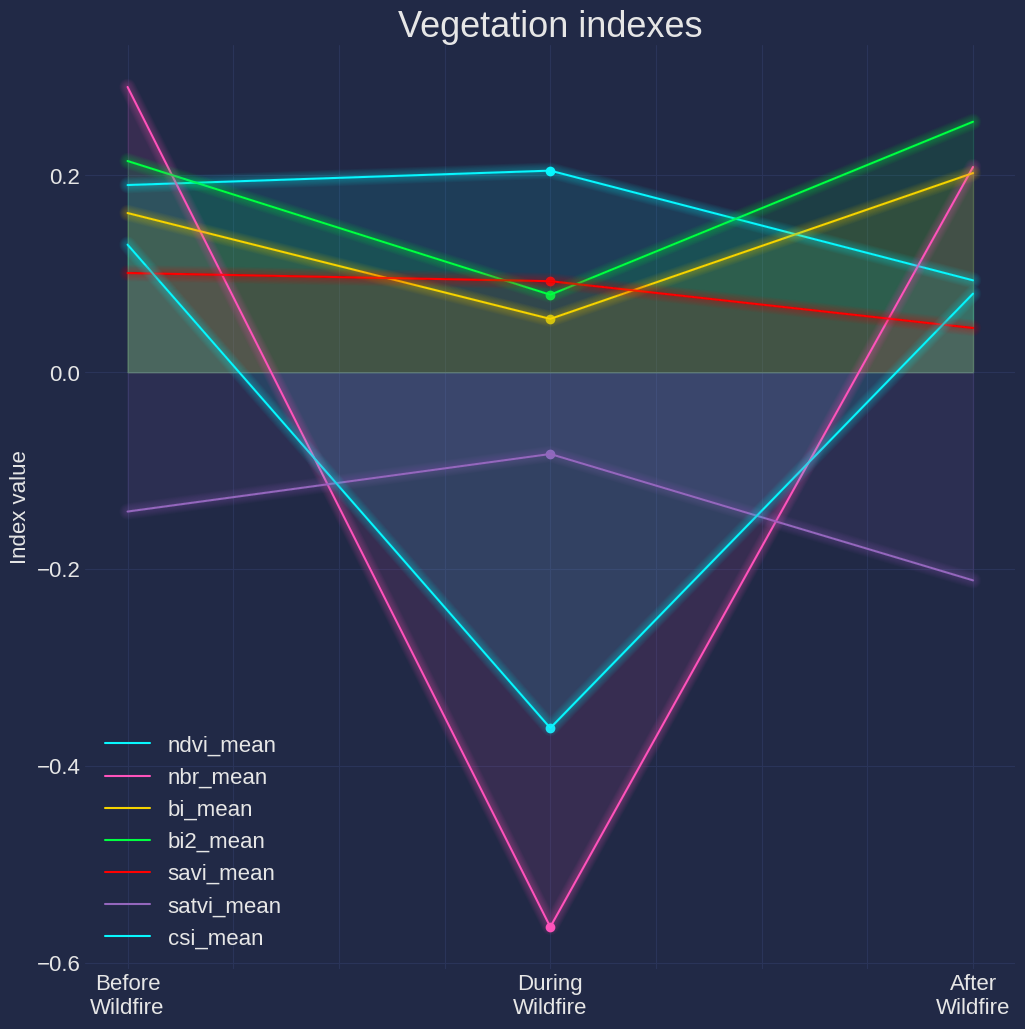

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,12))

lines = df.set_index('fire').plot(ax=ax).lines
line_colors = [line.get_color() for line in lines]
for i, col in enumerate(df.columns[1:]):
    ax.scatter(1, df[df.fire=='During\nWildfire'][col].values, color=line_colors[i])
ax.set_ylabel('Index value')
ax.set_xlabel('')
plt.legend()
ax.set_title('Vegetation indexes', fontsize=26)
mplcyberpunk.add_glow_effects()

plt.savefig(f'Indexes.png')
plt.show()

In [ ]:
query = """
DROP TABLE IF EXISTS Meteo;
CREATE TABLE Meteo AS
SELECT
    fire,
    AVG(mean_2m_air_temperature) AS t2m,
    AVG(total_precipitation) AS tp,
    AVG(surface_pressure) AS sp
FROM
    'meteo.csv'
GROUP BY
    fire;"""

con.execute(query)
df = con.execute("SELECT * FROM Meteo;").df()
df

fire         t2m        tp            sp
0     0  283.061386  0.001498  99635.872309
1     1  286.321163  0.000092  99963.414916
2     2  284.955043  0.002645  99169.791741

In [ ]:
df.t2m -= 273.15
df.sp /= 100
df.tp*=1e3

df = df.sort_values('fire')
df.fire = ['Before\nWildfire', 'During\nWildfire', 'After\nWildfire']
df = df.reset_index(drop=True)
df

fire        t2m        tp          sp
0  Before\nWildfire   9.911386  1.497949  996.358723
1  During\nWildfire  13.171163  0.091915  999.634149
2   After\nWildfire  11.805043  2.644949  991.697917

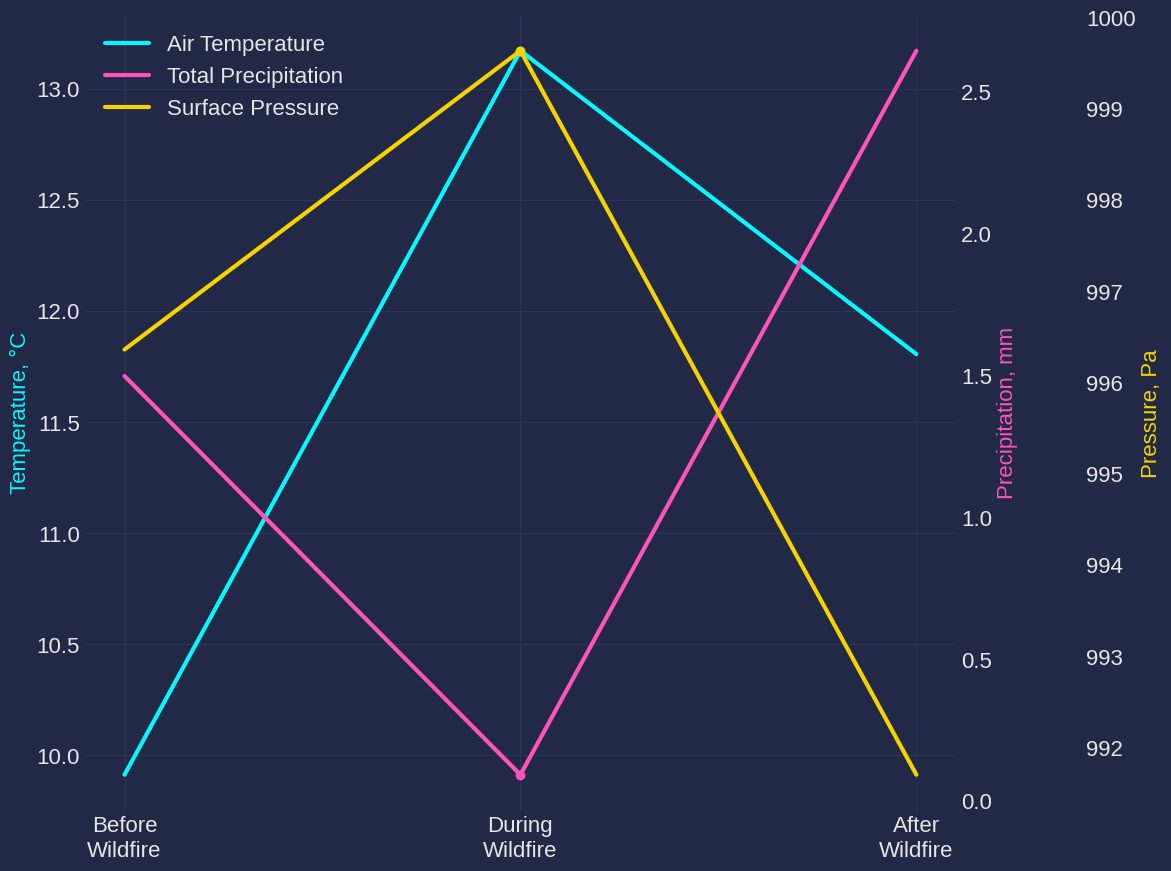

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,9))

# Plot y1 on primary y-axis
p1 = ax1.plot(df.fire, df.t2m, label='Air Temperature', color=line_colors[0], lw=3)
ax1.scatter([1], df.t2m[1], color=line_colors[0])
ax1.set_ylabel('Temperature, °C', color=line_colors[0])

ax2 = ax1.twinx()
p2 = ax2.plot(df.fire, df.tp, label='Total Precipitation', color=line_colors[1], lw=3)
ax2.scatter([1], df.tp[1], color=line_colors[1])
ax2.set_ylabel('Precipitation, mm', color=line_colors[1])

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 90))

p3 = ax3.plot(df.fire, df.sp, label='Surface Pressure', color=line_colors[2], lw=3)
ax3.set_ylabel('Pressure, Pa', color=line_colors[2])
ax3.scatter([1], df.sp[1], color=line_colors[2])

ax1.grid(True)
ax2.grid(False)
ax3.grid(False)

fig.tight_layout()
ax1.legend(handles=p1+p2+p3, loc='upper left')
plt.savefig(f'Meteo.png')

# Histograms

In [ ]:
df = pd.read_csv('Indexes.csv')
df

NDVI       NBR        BI       BI2      SAVI     SATVI  \
0         0.196679 -0.281844  0.076813  0.108668  0.128417 -0.104878   
1         0.196679 -0.281844  0.076813  0.108668  0.128417 -0.104878   
2         0.258860 -0.299242  0.063357  0.097417  0.160607 -0.059159   
3         0.258860 -0.299242  0.063357  0.097417  0.160607 -0.059159   
4         0.165725 -0.248786  0.085151  0.118585  0.114187 -0.145153   
...            ...       ...       ...       ...       ...       ...   
20492278  0.012025  0.465436  0.389386  0.479917  0.013868 -0.613505   
20492279  0.012025  0.465436  0.389386  0.479917  0.013868 -0.613505   
20492280  0.012025  0.469017  0.388817  0.479456  0.013868 -0.614737   
20492281  0.012060  0.467903  0.389203  0.479301  0.013899 -0.613215   
20492282  0.012060  0.467903  0.389203  0.479301  0.013899 -0.613215   

               CSI  fire  
0        -0.317542     1  
1        -0.317542     1  
2        -0.317542     1  
3        -0.317542     1  
4        -0.317542     1  
...            ...   ...  
20492278  0.018542     2  
20492279  0.018542     2  
20492280  0.019658     2  
20492281  0.019658     2  
20492282  0.019658     2  

[20492283 rows x 8 columns]

In [ ]:
df[df.fire==1]['NDVI']

0           0.196679
1           0.196679
2           0.258860
3           0.258860
4           0.165725
              ...   
20490254    0.230632
20490255    0.230632
20490256    0.456083
20490257    0.497549
20490258    0.497549
Name: NDVI, Length: 814063, dtype: float64

In [ ]:
'db'.upper()

'DB'

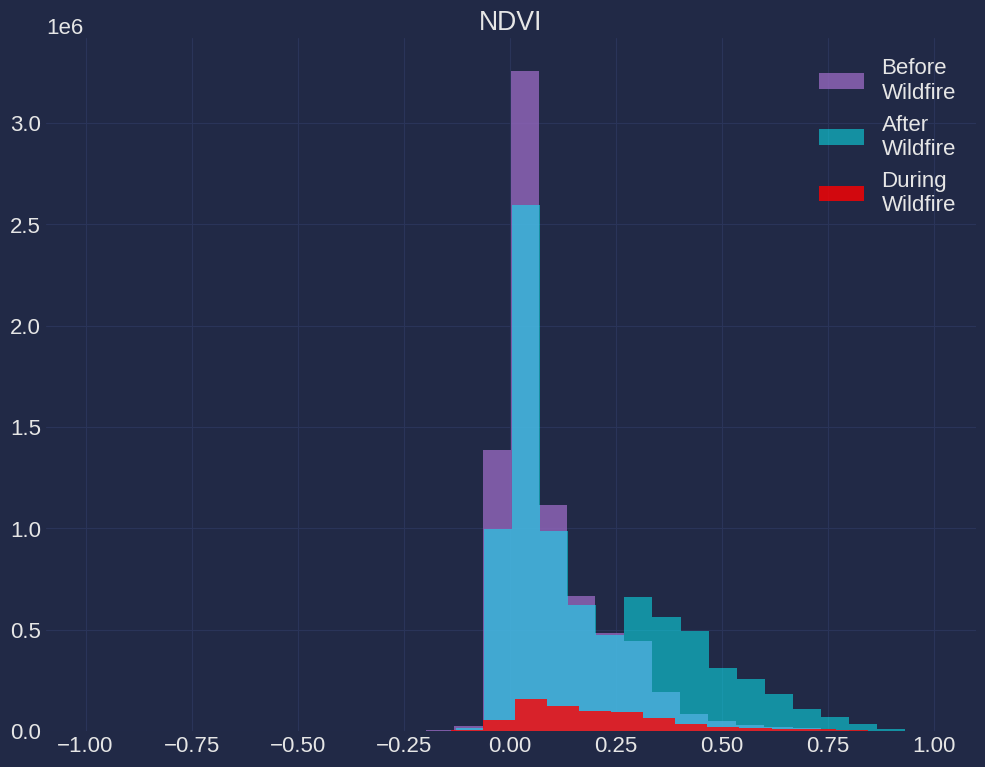

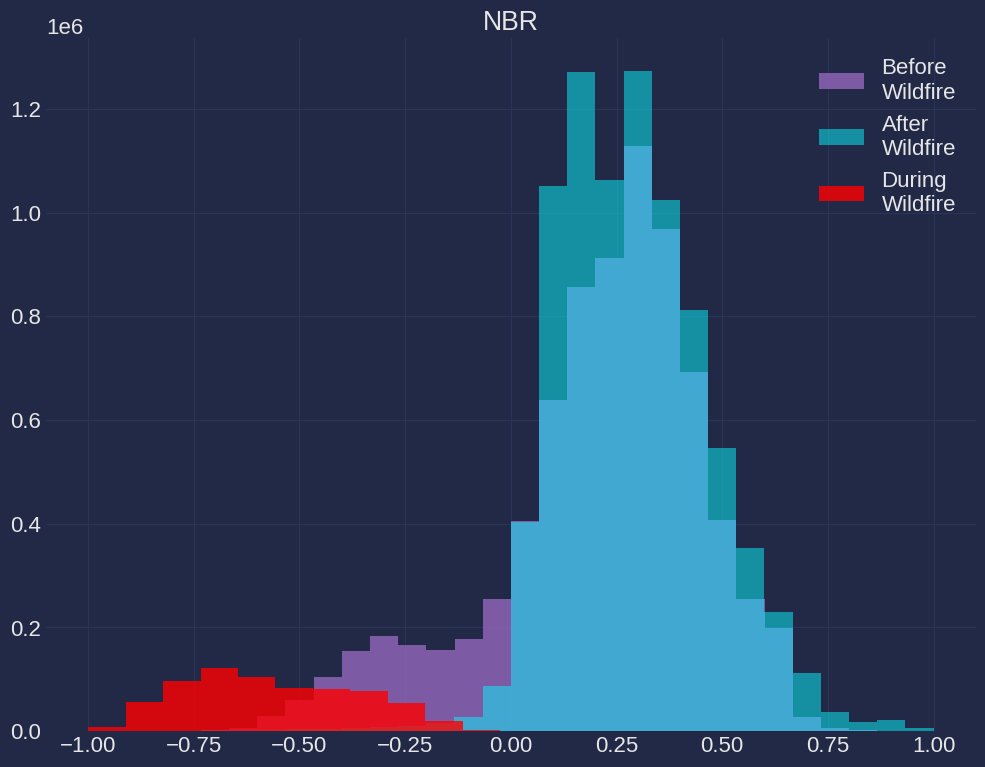

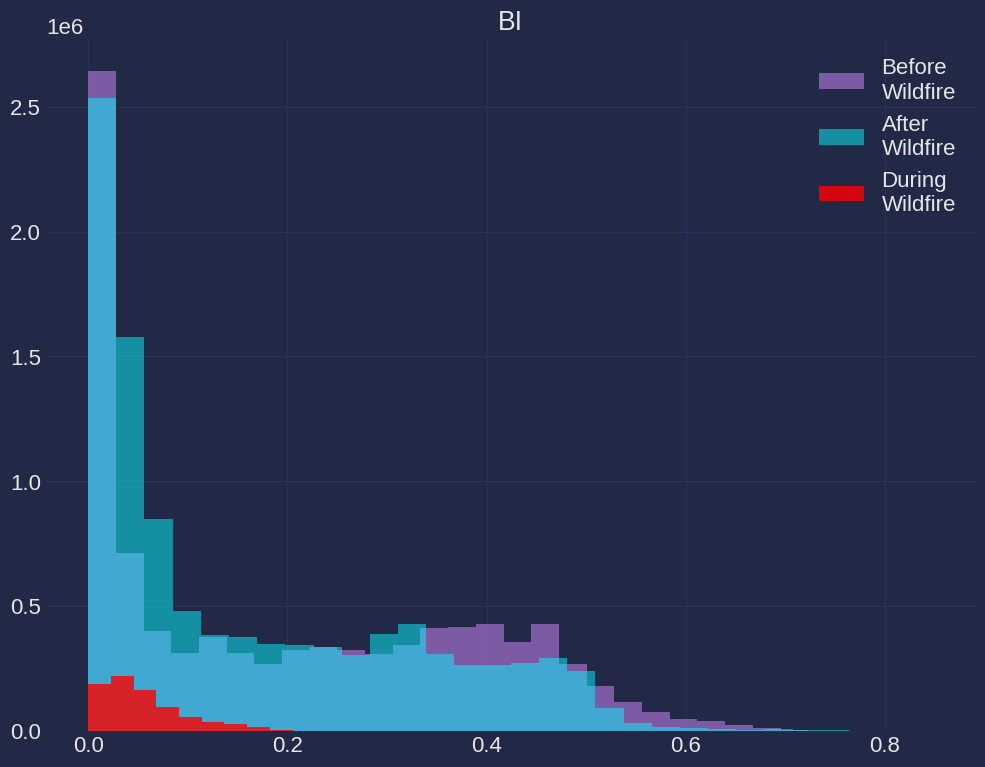

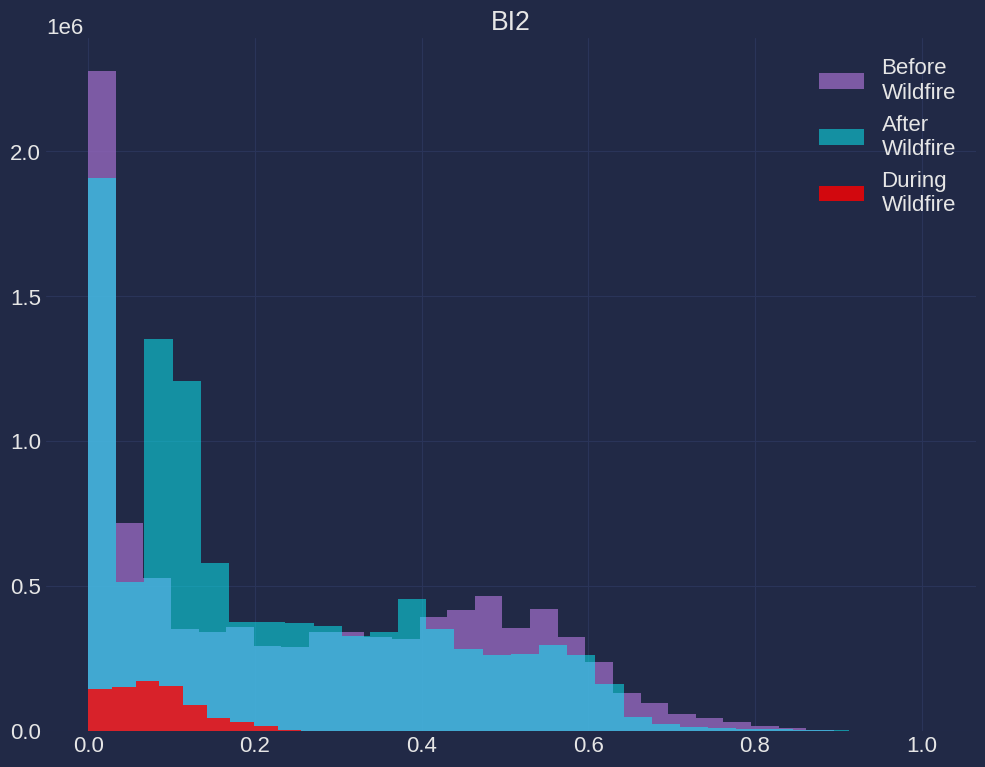

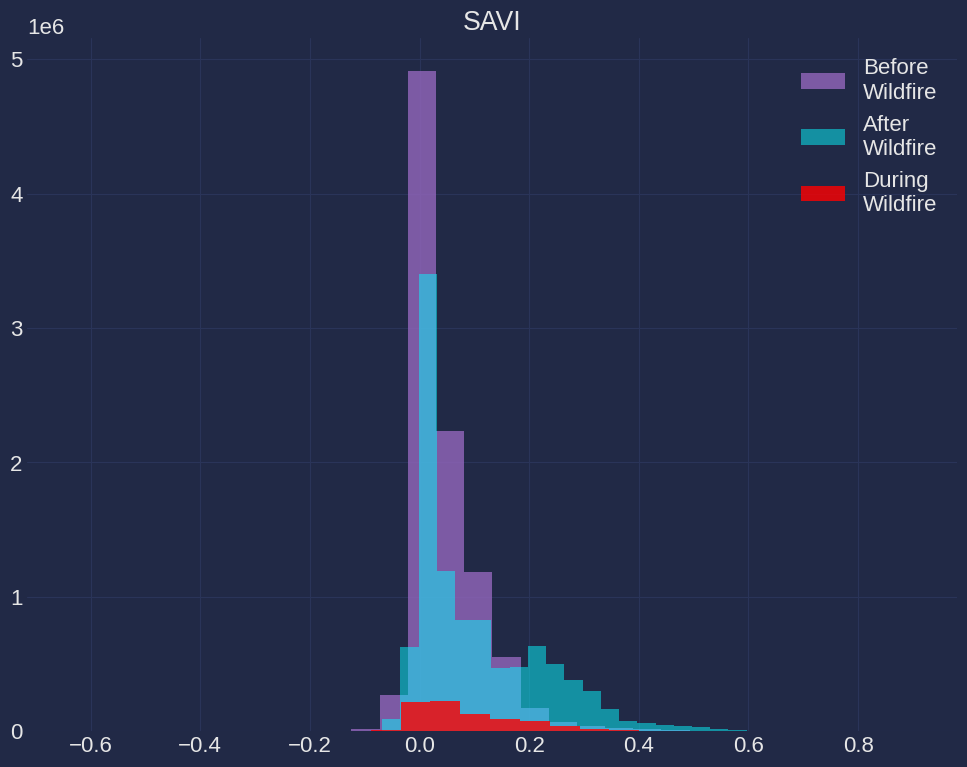

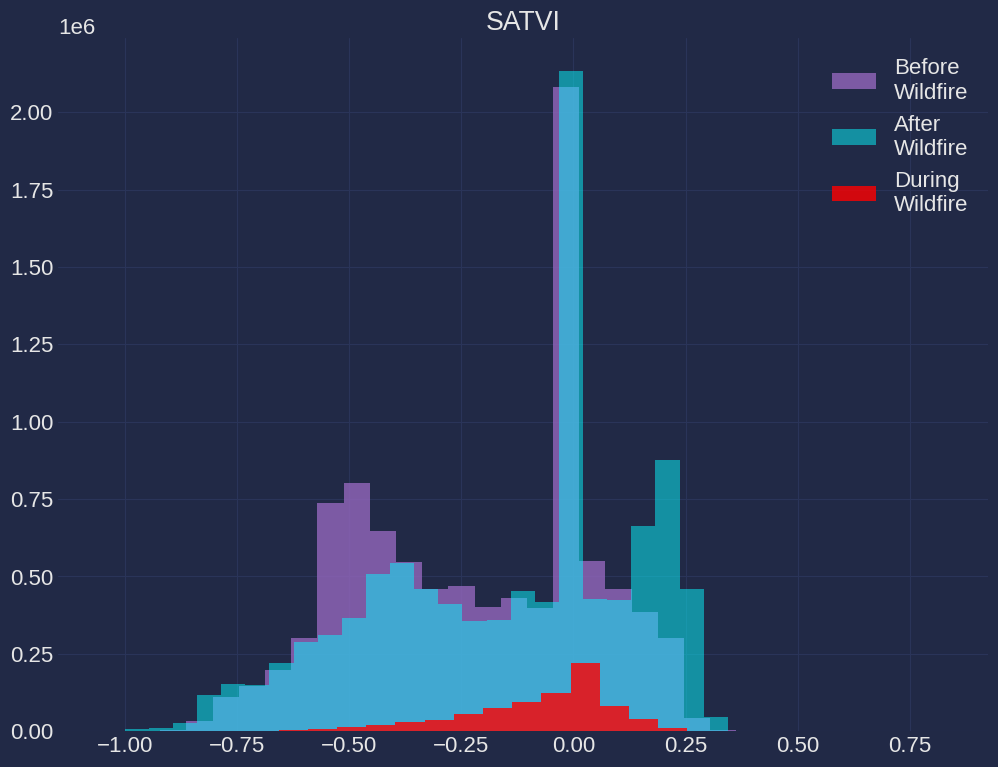

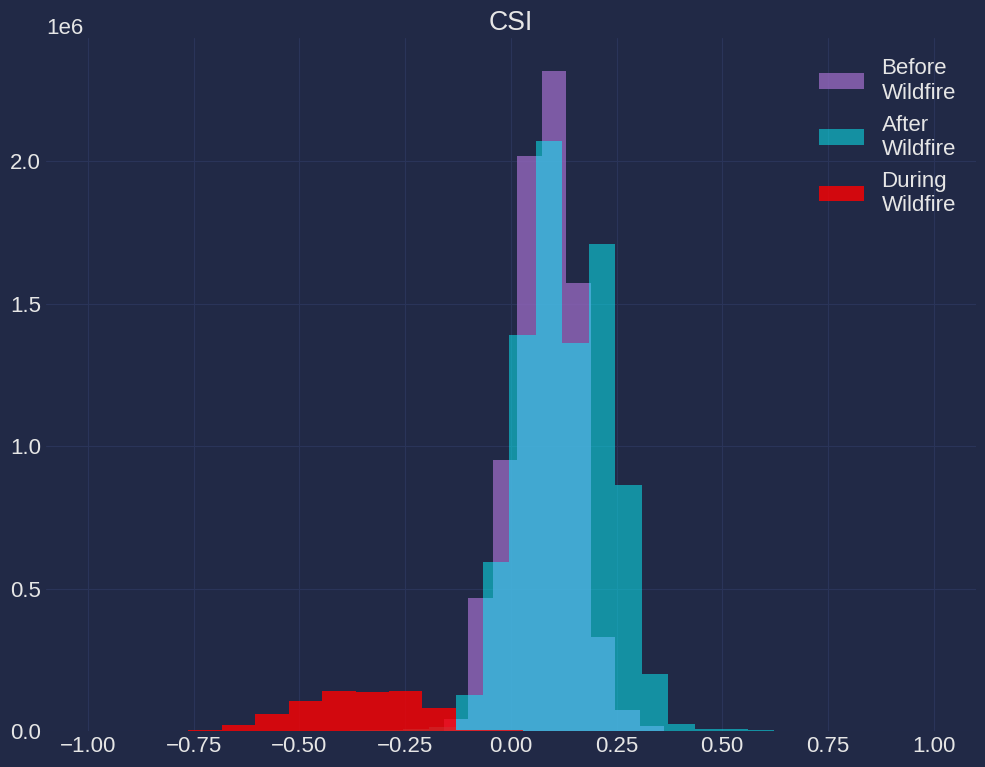

In [ ]:
for column in df.columns:
    if column!='fire':
        fig, ax = plt.subplots(figsize=(12,9))

        ax.hist(df[df.fire==2][column], color=line_colors[5], bins=30, alpha=0.8, label='Before\nWildfire')
        ax.hist(df[df.fire==0][column], color=line_colors[0], bins=30, alpha=0.5, label='After\nWildfire')
        ax.hist(df[df.fire==1][column], color=line_colors[4], bins=20, alpha=0.8, label='During\nWildfire')
        plt.title(column)
        plt.legend()
        plt.savefig(f'./hists/{column}.png')

In [ ]:
for column in df.columns[1:]:


# ML WF images

In [ ]:
dates = []
for i in range(len(df)):
    startDate = pd.to_datetime(df.acq_date.values[i])
    endDate = startDate+datetime.timedelta(days=1)
    S2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                .filterDate(startDate.strftime('%Y-%m-%d'), endDate.strftime('%Y-%m-%d'))\
                .filterBounds(points[i].buffer(2500).bounds())\
                .select(SBands)#\
                #.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))
    if S2.size().getInfo()!=0:
        S2_list = S2.toList(S2.size())
        for j in range(S2_list.size().getInfo()):
            img = ee.Image(S2_list.get(j)).select(SBands[:5])#.unmask(-9999)
            img = img.reproject('EPSG:4326', scale=10, crsTransform=None)
            roi = points[i].buffer(2500).bounds()#ee.Geometry.Rectangle(coords(lat, lon))
            array = ee.data.computePixels({
              'expression': img.clip(roi),
              'fileFormat': 'NUMPY_NDARRAY'
            })
            #if round(np.count_nonzero(array['B4'])/(array['B4'].shape[0]*array['B4'].shape[1]))>0.85:
            dates.append(startDate)
            np.save(join('./S2',f'{i}_{j}.npy'), array)
            print(f'Index: {i}/{len(df)-1}\tDate: {startDate}')
print('Done')

Index: 6/1086	Date: 2017-04-08 00:00:00
Index: 7/1086	Date: 2017-04-08 00:00:00
Index: 12/1086	Date: 2017-04-08 00:00:00
Index: 13/1086	Date: 2017-04-08 00:00:00
Index: 14/1086	Date: 2017-04-08 00:00:00
Index: 15/1086	Date: 2017-04-08 00:00:00
Index: 16/1086	Date: 2017-04-08 00:00:00
Index: 17/1086	Date: 2017-04-08 00:00:00
Index: 18/1086	Date: 2017-04-08 00:00:00
Index: 18/1086	Date: 2017-04-08 00:00:00
Index: 19/1086	Date: 2017-04-08 00:00:00
Index: 20/1086	Date: 2017-04-08 00:00:00
Index: 25/1086	Date: 2017-05-01 00:00:00
Index: 26/1086	Date: 2017-05-04 00:00:00
Index: 27/1086	Date: 2017-05-04 00:00:00
Index: 27/1086	Date: 2017-05-04 00:00:00
Index: 28/1086	Date: 2017-05-04 00:00:00
Index: 29/1086	Date: 2017-05-05 00:00:00
Index: 49/1086	Date: 2017-05-08 00:00:00
Index: 50/1086	Date: 2017-05-08 00:00:00
Index: 65/1086	Date: 2017-06-24 00:00:00
Index: 65/1086	Date: 2017-06-24 00:00:00
Index: 78/1086	Date: 2018-02-24 00:00:00
Index: 79/1086	Date: 2018-02-24 00:00:00
Index: 90/1086	Dat

In [ ]:
def img_vis(file, type='RGB', gamma=1.0):
    array = np.load(join('./S2',file))
    if type=='RGB':
        image = np.array([array['B4'][:, 192:694],array['B3'][:, 192:694],array['B2'][:, 192:694]])
        normalized_image = np.transpose((image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image)), (1,2,0))
    elif type=='B11':
        image = np.array(array['B11'][:, 192:694])
        normalized_image = (image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image))
    elif type=='B12':
        image = np.array(array['B12'][:, 192:694])
        normalized_image = (image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image))

    corrected_image = np.power(normalized_image, gamma)
    corrected_image = (corrected_image * 255).astype(np.uint8)

    return corrected_image

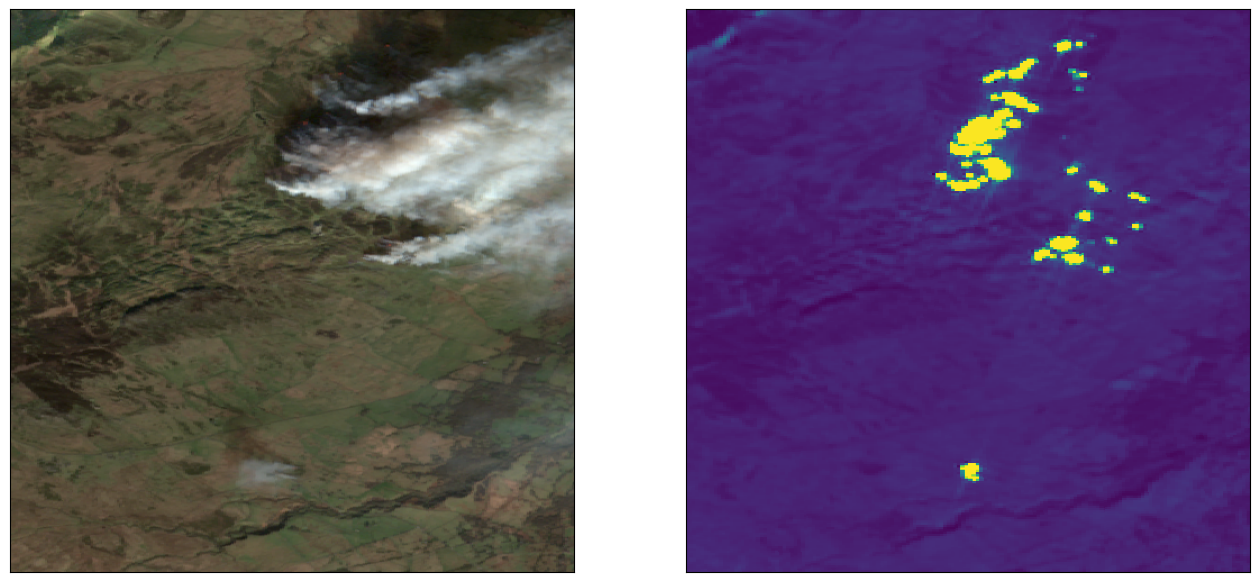

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,9))

ax[0].imshow(img_vis('346_1.npy', 'RGB', 0.6))
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(img_vis('346_1.npy', 'B12'))
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

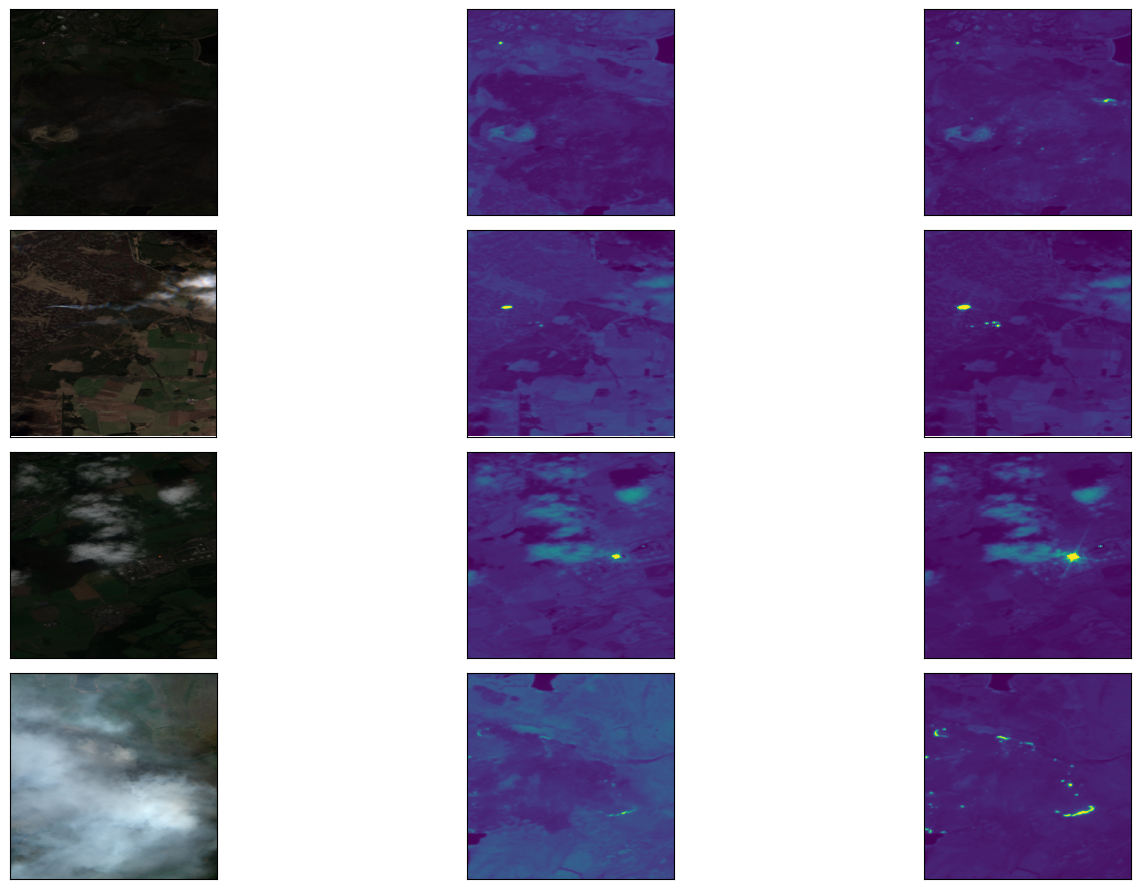

In [ ]:
files = listdir('./S2_img')
fig, ax = plt.subplots(4,3, figsize=(16,9))
for i in range(0,4):
    idx = random.randint(0, len(files)-1)

    ax[i,0].imshow(img_vis(files[idx].replace(".jpg", ".npy"), 'RGB', 0.8))
    #ax[i,0].set_title(f'{files[idx]}: RGB')
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])

    ax[i,1].imshow(img_vis(files[idx].replace(".jpg", ".npy"), 'B11'))
    #ax[i,1].set_title(f'{files[idx]}: SWIR1')
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])

    ax[i,2].imshow(img_vis(files[idx].replace(".jpg", ".npy"), 'B12'))
    #ax[i,2].set_title(f'{files[idx]}: SWIR2')
    ax[i,2].set_xticks([])
    ax[i,2].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
files = [x.split('.')[0] for x in listdir('./S2_img')]
i = 0
for f in files:
    image = Image.fromarray(img_vis(f+'.npy', 'RGB', 0.9))
    swir = np.array([Image.fromarray(img_vis(f+'.npy', 'B11')), Image.fromarray(img_vis(f+'.npy', 'B12'))])
    image.save(f'./S2_dataset/1/RGB/{i}.jpg')
    np.save(f'./S2_dataset/1/SWIR/{i}.npy', swir)
    i+=1
    image = image.rotate(180)
    image.save(f'./S2_dataset/1/RGB/{i}.jpg')
    np.save(f'./S2_dataset/1/SWIR/{i}.npy', swir[:,::-1])
    i+=1

# No-WF

In [ ]:
shape = gpd.read_file('./gadm41_GBR_shp/gadm41_GBR_0.shp')

In [ ]:
from shapely.geometry import Point

polygon = shape.geometry.iloc[0]

# Generate a random point within the polygon
min_x, min_y, max_x, max_y = polygon.bounds
points = []
while len(points)<300:
    random_point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
    if random_point.within(polygon):
        points.append(ee.Geometry.Point(random_point.xy[0][0],random_point.xy[1][0]))
print('Done!')

In [ ]:
random.randint(17,23)

21

In [ ]:
for i in range(len(points)):
    startDate = f'{random.randint(17,23)}-07-01'
    endDate = '2023-11-30'
    S2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                .filterDate(startDate, endDate)\
                .filterBounds(points[i].buffer(2500).bounds())\
                .select(SBands)\
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
    if S2.size().getInfo()!=0:
        S2_list = S2.toList(S2.size())

        img = ee.Image(S2_list.get(0)).select(SBands[:5])#.unmask(-9999)
        img = img.reproject('EPSG:4326', scale=10, crsTransform=None)
        roi = points[i].buffer(2500).bounds()#ee.Geometry.Rectangle(coords(lat, lon))
        array = ee.data.computePixels({
          'expression': img.clip(roi),
          'fileFormat': 'NUMPY_NDARRAY'
        })
        if round(np.count_nonzero(array['B4'])/(array['B4'].shape[0]*array['B4'].shape[1]))>0.9:
            np.save(join('./S2_land',f'{i}.npy'), array)
            print(f'Index: {i}/{len(points)-1}')
print('Done')

Index: 0/281
Index: 1/281
Index: 2/281
Index: 4/281
Index: 5/281
Index: 6/281
Index: 7/281
Index: 8/281
Index: 9/281
Index: 10/281
Index: 11/281
Index: 12/281
Index: 13/281
Index: 14/281
Index: 15/281
Index: 17/281
Index: 18/281
Index: 19/281
Index: 20/281
Index: 21/281
Index: 23/281
Index: 24/281
Index: 25/281
Index: 26/281
Index: 27/281
Index: 28/281
Index: 29/281
Index: 30/281
Index: 31/281
Index: 32/281
Index: 33/281
Index: 34/281
Index: 35/281
Index: 36/281
Index: 37/281
Index: 38/281
Index: 39/281
Index: 40/281
Index: 41/281
Index: 42/281
Index: 43/281
Index: 45/281
Index: 46/281
Index: 47/281
Index: 48/281
Index: 49/281
Index: 50/281
Index: 51/281
Index: 52/281
Index: 53/281
Index: 54/281
Index: 55/281
Index: 56/281
Index: 57/281
Index: 58/281
Index: 59/281
Index: 60/281
Index: 61/281
Index: 62/281
Index: 63/281
Index: 64/281
Index: 65/281
Index: 66/281
Index: 67/281
Index: 68/281
Index: 69/281
Index: 70/281
Index: 71/281
Index: 72/281
Index: 73/281
Index: 74/281
Index: 75/281
I

In [ ]:
def img_vis(file, type='RGB', gamma=1.0):
    array = np.load(join('./S2_land',file))
    if type=='RGB':
        image = np.array([array['B4'][:, 192:694],array['B3'][:, 192:694],array['B2'][:, 192:694]])
        normalized_image = np.transpose((image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image)), (1,2,0))
    elif type=='B11':
        image = np.array(array['B11'][:, 192:694])
        normalized_image = (image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image))
    elif type=='B12':
        image = np.array(array['B12'][:, 192:694])
        normalized_image = (image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image))

    corrected_image = np.power(normalized_image, gamma)
    corrected_image = (corrected_image * 255).astype(np.uint8)

    return corrected_image

In [ ]:
files = listdir('./S2_land')
for f in files:
    image = Image.fromarray(img_vis(f, 'RGB', 0.9))
    image.save(f'./S2_img_land/{f.split(".")[0]}.jpg')

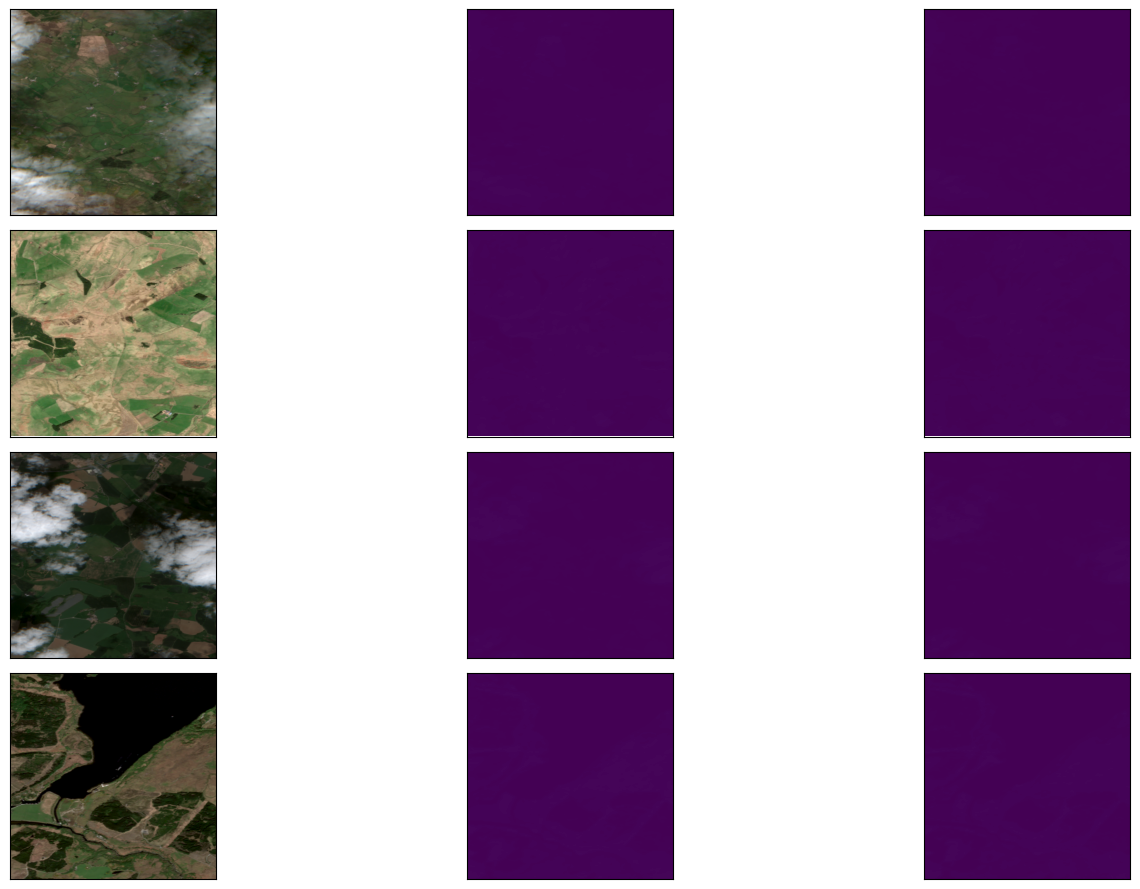

In [ ]:
files = listdir('./S2_img_land')
fig, ax = plt.subplots(4,3, figsize=(16,9))
for i in range(0,4):
    idx = random.randint(0, len(files)-1)

    ax[i,0].imshow(img_vis(files[idx].replace(".jpg", ".npy"), 'RGB', 0.6))
    #ax[i,0].set_title(f'{files[idx]}: RGB')
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])

    ax[i,1].imshow(img_vis(files[idx].replace(".jpg", ".npy"), 'B11'), vmax=1.5e4, vmin=0)
    #ax[i,1].set_title(f'{files[idx]}: SWIR1')
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])

    ax[i,2].imshow(img_vis(files[idx].replace(".jpg", ".npy"), 'B12'), vmax=1.5e4, vmin=0)
    #ax[i,2].set_title(f'{files[idx]}: SWIR2')
    ax[i,2].set_xticks([])
    ax[i,2].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
files = [x.split('.')[0] for x in listdir('./S2_img_land')]
i = 0
for f in files:
    image = Image.fromarray(img_vis(f+'.npy', 'RGB', 0.9))
    swir = np.array([Image.fromarray(img_vis(f+'.npy', 'B11')), Image.fromarray(img_vis(f+'.npy', 'B12'))])
    image.save(f'./S2_dataset/0/RGB/{i}.jpg')
    np.save(f'./S2_dataset/0/SWIR/{i}.npy', swir)
    i+=1
    image = image.rotate(180)
    image.save(f'./S2_dataset/0/RGB/{i}.jpg')
    np.save(f'./S2_dataset/0/SWIR/{i}.npy', swir[:,::-1])
    i+=1

In [ ]:
map = geemap.Map(center=[55, 0], zoom=6)
# firesVis = {
#   'min': 60,
#   'max': 100.0,
#   'palette': ['red'],
# }
s2Vis = {
    'min': 0,
    'max': 0.3,
    'gamma': 1.1
}
map.add_ee_layer(ee.Image(S2.first()).clip(points[21].buffer(2000)).select(SBands[:3][::-1]), s2Vis)
map.add_ee_layer(points[21].buffer(2000), {'opacity': 0.4})
map

Map(center=[55, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

# Getting validation data

In [ ]:
val = pd.read_csv('Validation_data.csv')
val

Date            Date/Time  Longitude   Latitude      Time  \
0     5/30/2020  30/05/2020 13:15:47  -2.934030  52.780690  13:15:47   
1     7/24/2018  24/07/2018 15:15:10  -2.521770  52.690140  15:15:10   
2     8/10/2019  10/08/2019 17:51:43  -2.302040  52.658930  17:51:43   
3      8/1/2021  01/08/2021 19:18:17  -2.464970  52.669220  19:18:17   
4     7/16/2022  16/07/2022 13:10:08  -2.561360  52.897740  13:10:08   
..          ...                  ...        ...        ...       ...   
156   9/21/2022  21/09/2022 19:53:32  -2.741689  52.740765  19:53:32   
157  12/14/2020  14/12/2020 02:11:13  -2.721113  52.713132  02:11:13   
158   4/25/2021  25/04/2021 14:37:32  -2.430023  52.699881  14:37:32   
159   1/20/2020  20/01/2020 13:17:34  -2.440871  52.650578  13:17:34   
160   8/15/2022  15/08/2022 17:58:21  -2.517071  52.687834  17:58:21   

         Month  
0          May  
1         July  
2       August  
3       August  
4         July  
..         ...  
156  September  
157   December  
158      April  
159    January  
160     August  

[161 rows x 6 columns]

In [ ]:
points = []
for i in range(len(val)):
    points.append(ee.Geometry.Point([val.Longitude.values[i], val.Latitude.values[i]]))

In [ ]:
dates = []
for i in range(len(val)):
    startDate = pd.to_datetime(val.Date.values[i])
    endDate = startDate+datetime.timedelta(days=1)
    S2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                .filterDate(startDate.strftime('%Y-%m-%d'), endDate.strftime('%Y-%m-%d'))\
                .filterBounds(points[i].buffer(2500).bounds())\
                .select(SBands)#\
                #.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))
    if S2.size().getInfo()!=0:
        S2_list = S2.toList(S2.size())
        for j in range(S2_list.size().getInfo()):
            img = ee.Image(S2_list.get(j)).select(SBands[:5])#.unmask(-9999)
            img = img.reproject('EPSG:4326', scale=10, crsTransform=None)
            roi = points[i].buffer(2500).bounds()#ee.Geometry.Rectangle(coords(lat, lon))
            array = ee.data.computePixels({
              'expression': img.clip(roi),
              'fileFormat': 'NUMPY_NDARRAY'
            })
            #if round(np.count_nonzero(array['B4'])/(array['B4'].shape[0]*array['B4'].shape[1]))>0.85:
            dates.append(startDate)
            np.save(join('./val',f'{i}_{j}.npy'), array)
            print(f'Index: {i}/{len(val)-1}\tDate: {startDate}')
print('Done')

Index: 1/160	Date: 2018-07-24 00:00:00
Index: 2/160	Date: 2019-08-10 00:00:00
Index: 6/160	Date: 2023-02-03 00:00:00
Index: 8/160	Date: 2019-04-22 00:00:00
Index: 9/160	Date: 2022-04-14 00:00:00
Index: 10/160	Date: 2022-08-27 00:00:00
Index: 10/160	Date: 2022-08-27 00:00:00
Index: 12/160	Date: 2022-07-13 00:00:00
Index: 17/160	Date: 2018-11-06 00:00:00
Index: 18/160	Date: 2022-07-13 00:00:00
Index: 25/160	Date: 2019-04-20 00:00:00
Index: 30/160	Date: 2019-02-26 00:00:00
Index: 31/160	Date: 2021-01-01 00:00:00
Index: 35/160	Date: 2022-04-24 00:00:00
Index: 36/160	Date: 2018-07-09 00:00:00
Index: 37/160	Date: 2020-05-27 00:00:00
Index: 38/160	Date: 2022-09-01 00:00:00
Index: 38/160	Date: 2022-09-01 00:00:00
Index: 39/160	Date: 2022-07-18 00:00:00
Index: 39/160	Date: 2022-07-18 00:00:00
Index: 42/160	Date: 2019-03-31 00:00:00
Index: 42/160	Date: 2019-03-31 00:00:00
Index: 46/160	Date: 2018-07-14 00:00:00
Index: 48/160	Date: 2022-07-18 00:00:00
Index: 49/160	Date: 2022-07-18 00:00:00
Index

In [ ]:
def img_vis(file, type='RGB', gamma=1.0):
    array = np.load(join('./val',file))
    if type=='RGB':
        image = np.array([array['B4'][:, 192:694],array['B3'][:, 192:694],array['B2'][:, 192:694]])
        normalized_image = np.transpose((image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image)), (1,2,0))
    elif type=='B11':
        image = np.array(array['B11'][:, 192:694])
        normalized_image = (image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image))
    elif type=='B12':
        image = np.array(array['B12'][:, 192:694])
        normalized_image = (image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image))

    corrected_image = np.power(normalized_image, gamma)
    corrected_image = (corrected_image * 255).astype(np.uint8)

    return corrected_image

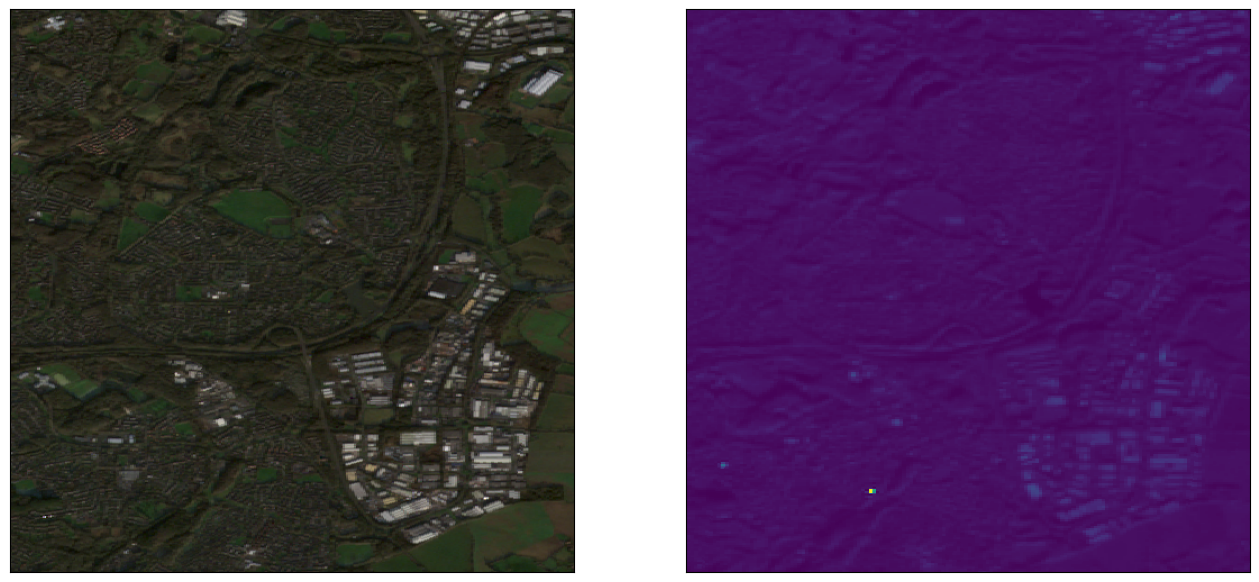

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,9))

ax[0].imshow(img_vis('159_0.npy', 'RGB', 0.6))
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(img_vis('159_0.npy', 'B12'))
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

In [ ]:
files = [x.split('.')[0] for x in listdir('./val_img')]
i = 0
for f in files:
    image = Image.fromarray(img_vis(f+'.npy', 'RGB', 0.6))
    swir = np.array([Image.fromarray(img_vis(f+'.npy', 'B11')), Image.fromarray(img_vis(f+'.npy', 'B12'))])
    image.save(f'./val_dataset/RGB/{i}.jpg')
    np.save(f'./val_dataset/SWIR/{i}.npy', swir)
    i+=1

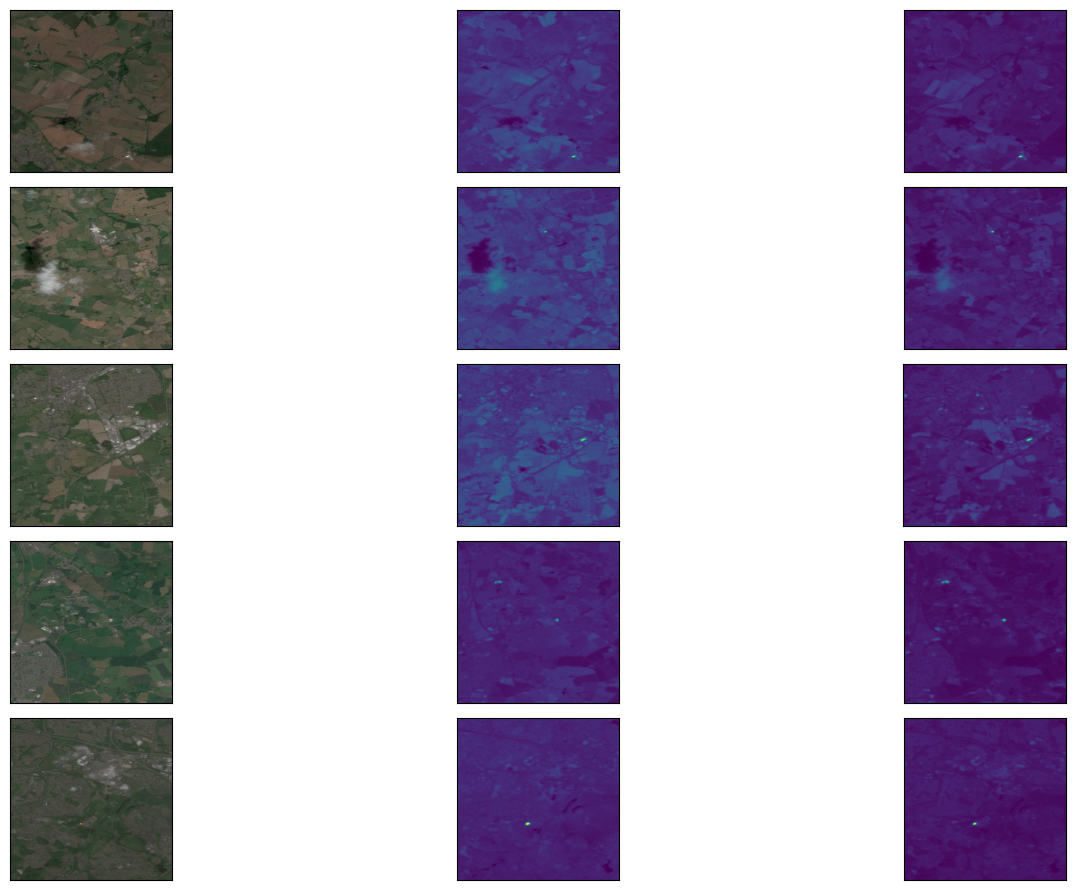

In [ ]:
files = listdir('./val_img')
fig, ax = plt.subplots(5,3, figsize=(16,9))
for i in range(0,5):

    ax[i,0].imshow(img_vis(files[i].replace(".jpg", ".npy"), 'RGB', 0.4))
    #ax[i,0].set_title(f'{files[idx]}: RGB')
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])

    ax[i,1].imshow(img_vis(files[i].replace(".jpg", ".npy"), 'B11'))
    #ax[i,1].set_title(f'{files[idx]}: SWIR1')
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])

    ax[i,2].imshow(img_vis(files[i].replace(".jpg", ".npy"), 'B12'))
    #ax[i,2].set_title(f'{files[idx]}: SWIR2')
    ax[i,2].set_xticks([])
    ax[i,2].set_yticks([])

plt.tight_layout()
plt.show()